<a href="https://colab.research.google.com/github/Aditya5437/NLP-PROJECTS-/blob/main/NLP_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Amazon-Product-Review-Sentiment-Analysis-using-RNN-Dataset.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())

(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [3]:
print("Null Values:\n", data.isna().sum())

Null Values:
 Review       1
Sentiment    0
dtype: int64


In [4]:
data = data.dropna()

In [5]:
print("Null values after dropping:\n" , data.isna().sum())

Null values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [6]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()

,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
def clean_reviews(text):
  regex = re.compile('<.*?>') # r'<.*?>'
  text = re.sub(regex, '', text)
  # removing special characters
  pattern = re.compile('[^a-zA-z0-9\s]')
  text = re.sub(pattern, '', text)
  # removing numbers
  pattern = re.compile('\d+')
  text = re.sub(pattern, '', text)
  text = text.lower()

  #tokenizing words
  text = word_tokenize(text)
  text = [word for word in text if word not in stop_words]
  return text
  data['Review'] = data['Review'].apply(clean_reviews)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
tokenizer = Tokenizer()
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)
max_words = 500


padded_sequences = pad_sequences(text_sequences, maxlen = max_words)
text_sequences = np.array(padded_sequences)

# now one hot encoding
data = pd.get_dummies(data, columns = ['Sentiment'])


X = pad_sequences(text_sequences, maxlen = max_words)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
    'Sentiment_5']]
print(X.shape, y.shape)


(24999, 500) (24999, 5)


In [9]:
#Train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19999, 500) (5000, 500) (19999, 5) (5000, 5)


Building the model using RNN

In [10]:
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1, max_words, input_length=max_words))
rnn.add(SimpleRNN(128,activation='relu', return_sequences=True))
rnn.add(SimpleRNN(64,activation='relu', return_sequences=False))
rnn.add(Dense(5, activation='softmax'))  # fully connected layer

rnn.build((None, max_words))  # problem solver which built the model

# printing summary of model
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 500)            │      14,614,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 500, 128)            │          80,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,707,189 (56.10 MB)

 Trainable params: 14,707,189 (56.10 MB)

 Non-trainable params: 0 (0.00 B)

None


RNN ACCURACY AND COMPILING THE MODEL AND MODEL EVALUATION

In [11]:
# Compiling model
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - accuracy: 0.2588 - loss: 90.4168 - val_accuracy: 0.4066 - val_loss: 1.3357
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.5034 - loss: 1.1861 - val_accuracy: 0.4062 - val_loss: 1.3182
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4079 - loss: 1.3230
Simple_RNN Score--->  [1.3181923627853394, 0.40619999170303345]


USING LSTM (LONG SHORT TERM MEMORY)

In [13]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
                    max_words,
                    input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# Build the model with the input shape
model.build((None, max_words))  # Replace None with your batch size if desired

# printing model summary
print(model.summary())

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 500, 500)            │      14,614,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150)                 │         390,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 150)                 │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           7,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,013,205 (57.27 MB)

 Trainable params: 15,012,805 (57.27 MB)

 Non-trainable params: 400 (1.56 KB)

None


In [14]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=3,
                         verbose=1,
                       validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.2696 - loss: 2.0796 - val_accuracy: 0.4356 - val_loss: 1.3316
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.4560 - loss: 1.2595 - val_accuracy: 0.4672 - val_loss: 1.2510
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.5697 - loss: 1.0092 - val_accuracy: 0.4364 - val_loss: 1.2682
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4361 - loss: 1.2694
LSTM model Score--->  [1.2682007551193237, 0.43639999628067017]


more accuracy which is 43% using LSTM


Classification Report

Text(0, 0.5, 'Accuracy')

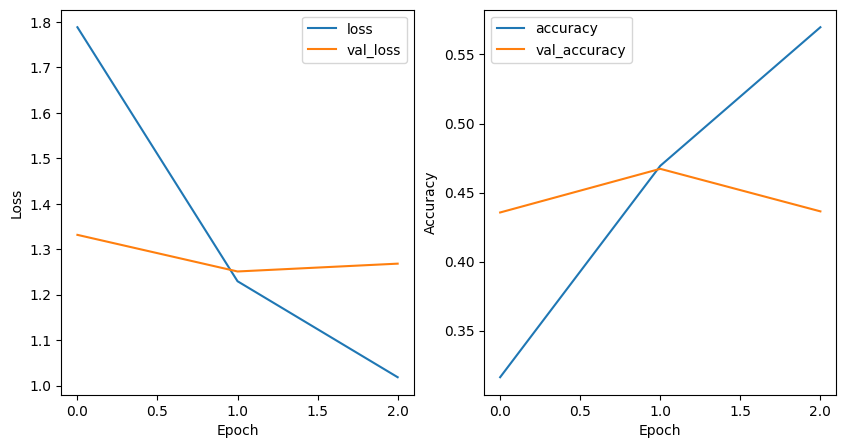

In [15]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


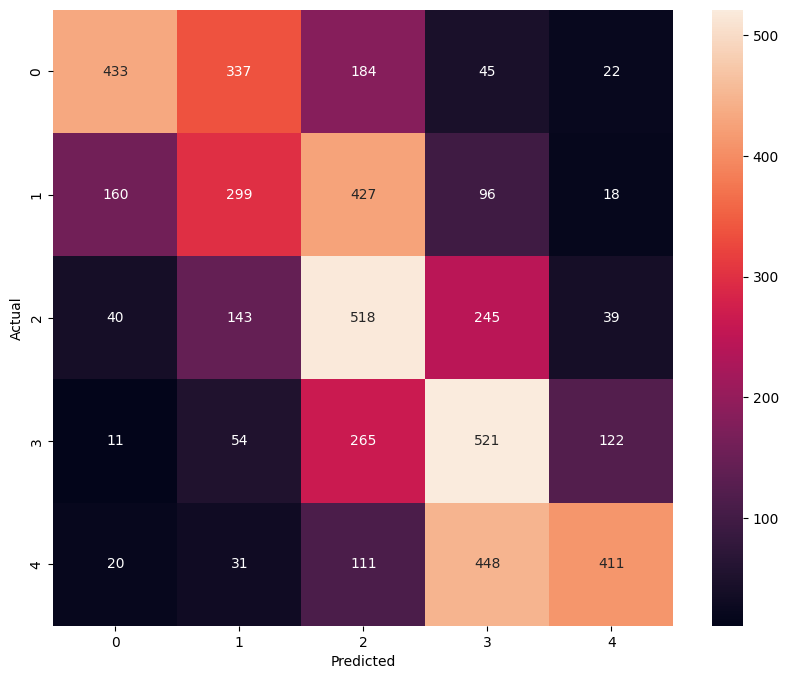

In [16]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

REPORT:

In [17]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.42      0.51      1021
           1       0.35      0.30      0.32      1000
           2       0.34      0.53      0.42       985
           3       0.38      0.54      0.45       973
           4       0.67      0.40      0.50      1021

    accuracy                           0.44      5000
   macro avg       0.48      0.44      0.44      5000
weighted avg       0.48      0.44      0.44      5000



Testing our Trained Model

In [19]:
def predict_review_rating(text):
  text_sequences_test = np.array(tokenizer.texts_to_sequences([text]))
  testing = pad_sequences(text_sequences_test, maxlen = max_words)
  y_pred_test = np.argmax(model.predict(testing), axis=1)
  return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('Shipped very quickly, but with no instructions.  My husband researched on YouTube and spent hours trying to fix Ipod Touch.  Terrible product; impossible to use.')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product,  I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The rating according to the review is:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
The rating according to the review is:  5
